# Convert Yolo V7 to ONNX and OpenVINO™ IR

This short tutorial demonstrates step-by-step instruction how to convert Pytorch Yolo V7 to OpenVINO IR. 

This tutorial consists of the following steps:
- Prepare PyTorch model
- Download and prepare dataset
- Validate original model
- Convert PyTorch model to ONNX
- Convert ONNX model to OpenVINO IR
- Validate converted model
- Prepare and run optimization pipeline
- Compare accuracy of the FP32 and quantized models.
- Compare performance of the FP32 and quantized models.

## Get Pytorch model

Generally, PyTorch model represents instance of torch.nn.Module class, iniatilized by state dictionary with model weights.
We will use YOLOv7 tiny model pretrained on COCO dataset, which available in this [repo](https://github.com/WongKinYiu/yolov7).
Typical steps for getting pretrained model:
1. Create instance of model class
2. Load checkpoint state dict, which contains pretrained model weights
3. Turn model to evaluation for switching some operations to inference mode

In our case, model authors already provide tool which allow to convert model to ONNX, so it is not necessary to do these steps manually.

## Prerequisites

In [2]:
import sys
from pathlib import Path
sys.path.append("../utils")
from notebook_utils import download_file

In [5]:
# Download YOLOv7 code
!git clone https://github.com/WongKinYiu/yolov7
%cd yolov7


Cloning into 'yolov7'...
remote: Enumerating objects: 998, done.
remote: Total 998 (delta 0), reused 0 (delta 0), pack-reused 998
Receiving objects: 100% (998/998), 69.77 MiB | 4.45 MiB/s, done.
Resolving deltas: 100% (466/466), done.
/home/ea/work/openvino_notebooks/notebooks/225-yolov7-optimization/yolov7


In [6]:
# Download pretrained model weights
MODEL_LINK = "https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-tiny.pt"
DATA_DIR = Path("data/")
MODEL_DIR = Path("model/")
MODEL_DIR.mkdir(exist_ok=True)
DATA_DIR.mkdir(exist_ok=True)

download_file(MODEL_LINK, directory=MODEL_DIR, show_progress=True)


model/yolov7-tiny.pt:   0%|          | 0.00/12.1M [00:00<?, ?B/s]

PosixPath('/home/ea/work/openvino_notebooks/notebooks/225-yolov7-optimization/yolov7/model/yolov7-tiny.pt')

## Check model inference

`detect.py` script run pytorch model inference and save image as result,

In [9]:
!python detect.py --weights model/yolov7-tiny.pt --conf 0.25 --img-size 640 --source inference/images/horses.jpg


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='inference/images/horses.jpg', update=False, view_img=False, weights=['model/yolov7-tiny.pt'])
YOLOR 🚀 v0.1-115-g072f76c torch 1.13.0+cu117 CPU

Fusing layers... 
Model Summary: 200 layers, 6219709 parameters, 229245 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/home/ea/work/notebooks_env/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Traceback (most recent call last):
  File "detect.py", line 196, in <module>
    detect()
  File "detect.py", line 92, in 

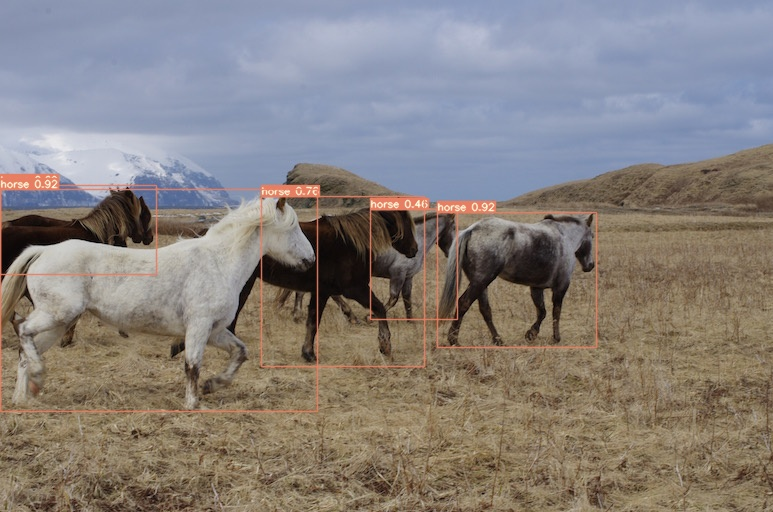

In [5]:
# visualize prediction result
from PIL import Image
Image.open('runs/detect/exp/horses.jpg')


## Export to ONNX

In order to obtain ONNX model, we will use `export.py` script. Let's check it's arguments.

In [6]:
!python export.py - -help


Import onnx_graphsurgeon failure: No module named 'onnx_graphsurgeon'
usage: export.py [-h] [--weights WEIGHTS] [--img-size IMG_SIZE [IMG_SIZE ...]]
                 [--batch-size BATCH_SIZE] [--dynamic] [--dynamic-batch]


c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


                 [--grid] [--end2end] [--max-wh MAX_WH] [--topk-all TOPK_ALL]
                 [--iou-thres IOU_THRES] [--conf-thres CONF_THRES]
                 [--device DEVICE] [--simplify] [--include-nms] [--fp16]
                 [--int8]

optional arguments:
  -h, --help            show this help message and exit
  --weights WEIGHTS     weights path
  --img-size IMG_SIZE [IMG_SIZE ...]
                        image size
  --batch-size BATCH_SIZE
                        batch size
  --dynamic             dynamic ONNX axes
  --dynamic-batch       dynamic batch onnx for tensorrt and onnx-runtime
  --grid                export Detect() layer grid
  --end2end             export end2end onnx
  --max-wh MAX_WH       None for tensorrt nms, int value for onnx-runtime nms
  --topk-all TOPK_ALL   topk objects for every images
  --iou-thres IOU_THRES
                        iou threshold for NMS
  --conf-thres CONF_THRES
                        conf threshold for NMS
  --device DEVICE       

The most important parameters:
* `--weights` - path to model weigths checkpoint
* `--img-size` - size of input image for onnx tracing

As ONNX is less flexible format then PyTorch, there is also opportunity to setup configurable parameters for results postprocessing included in model:
* `--end2end` - export full model to onnx including postporcessing
* `--grid` - export Detect layer as part of model
* `--topk-all` - topk elements for all images
* `--iou-thres` - intersection over union threshold for NMS
* `--conf-thres` - minimal confidence threshold
* `--max-wh` - max bounding box width and height for NMS

In [7]:
!python export.py - -weights model/yolov7-tiny.pt \
    - -grid - -end2end - -simplify \
    - -topk-all 100 - -iou-thres 0.65 - -conf-thres 0.35 \
    - -img-size 640 640 - -max-wh 640


Import onnx_graphsurgeon failure: No module named 'onnx_graphsurgeon'
Namespace(weights='model/yolov7-tiny.pt', img_size=[640, 640], batch_size=1, dynamic=False, dynamic_batch=False, grid=True, end2end=True, max_wh=640, topk_all=100, iou_thres=0.65, conf_thres=0.35, device='cpu', simplify=True, include_nms=False, fp16=False, int8=False)
Fusing layers... 

Starting TorchScript export with torch 1.11.0+cpu...
TorchScript export success, saved as model/yolov7-tiny.torchscript.pt
CoreML export failure: No module named 'coremltools'

Starting TorchScript-Lite export with torch 1.11.0+cpu...
TorchScript-Lite export success, saved as model/yolov7-tiny.torchscript.ptl

Starting ONNX export with onnx 1.11.0...
onnxruntime

Starting to simplify ONNX...
ONNX export success, saved as model/yolov7-tiny.onnx

Export complete (10.89s). Visualize with https://github.com/lutzroeder/netron.


c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\eaidova\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
YOLOR  v0.1-115-g072f76c torch 1.11.0+cpu CPU

Model Summary: 200 layers, 6219709 parameters, 6219709 gradients
c:\Users\eaidova\Anaconda3\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\eaidova\repos\openvino_notebooks\notebooks\102-pytorch-onnx-to-openvino\1

## Convert ONNX Model to OpenVINO Intermideate Representation
While ONNX models are directly supported by OpenVINO™, it can be useful to convert them to IR format to take advantage of OpenVINO optimization tools and features.
`mo.convert` function can be used for converting model using OpenVINO Model Optimizer capabilities. 
It returns of instance OpenVINO Model class, which is ready to use in python interface and can be serialized to IR for future execution.

In [8]:
from openvino.tools import mo
from openvino.runtime import serialize

model = mo.convert(input_model='model/yolov7-tiny.onnx')
# serialize model for saving IR
serialize(model, 'model/yolov7-tiny.xml')


## Verify model inference

In [3]:
import cv2
import numpy as np

# define preprocessing

def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - \
        new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right,
                            cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)


names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush']
colors = {name: [np.random.randint(0, 255) for _ in range(3)]
          for i, name in enumerate(names)}


In [12]:
def get_boxes(output, dwdh, ratio, flatten=False):
    batch_ids = int(np.max(output[:, 0]))
    total_boxes, total_labels, total_scores = [], [], []
    total_predictions = []
    for batch_id in range(batch_ids + 1):
        boxes, scores, labels = [], [], []
        predictions = []
        batch_elem_out = output[output[:, 0] == batch_id]
        for (_, x0, y0, x1, y1, cls_id, score) in output:
            box = np.array([x0,y0,x1,y1])
            box -= np.array(dwdh*2)
            box /= ratio
            score = float(score)
            if not flatten:
                boxes.append(box)
                scores.append(score)
                labels.append(cls_id)
            else:
                predictions.append(np.array([*box, score, cls_id]))
        total_boxes.append(boxes)
        total_labels.append(labels)
        total_scores.append(scores)
        total_predictions.append(predictions)
    if not flatten:
        return total_boxes, total_scores, total_labels
    return total_predictions


def draw_boxes(images, total_boxes, total_scores, total_labels):
    images_with_boxes = []
    for img, boxes, scores, labels in zip(images, total_boxes, total_scores, total_labels):
        if not boxes:
            continue
        for box, score, cls_id in zip(boxes, scores, labels):
            box = box.round().astype(np.int32).tolist()
            cls_id = int(cls_id)
            score = round(float(score),3)
            name = names[cls_id]
            color = colors[name]
            name += ' '+str(score)
            img = cv2.rectangle(img, box[:2], box[2:], color, 2)
            img = cv2.putText(img, name,(box[0], box[1] - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.75, [225, 255, 255], thickness=2)
        images_with_boxes.append(img)
        return images_with_boxes
        

In [10]:
def preprocess_image(img):
    # Model expect input with RGB channels order, while opencv reads in BGR, we need to swap channels for getting correct results
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    image = img.copy()
    # Resize image using letterbox resize approach defined above
    image, ratio, dwdh = letterbox(image, auto=False)

    # transpose layout from HWC to CHW
    image = image.transpose((2, 0, 1))

    # expand dims to get batch of images
    image = np.expand_dims(image, 0)
    image = np.ascontiguousarray(image)

    im = image.astype(np.float32)
    # normalize image to range [0, 1]
    im /= 255
    return im, ratio, dwdh


In [7]:
from openvino.runtime import Core
core = Core()
# read converted model
model = core.read_model('model/yolov7-tiny.xml')
# load model on CPU device
compiled_model = core.compile_model(model, 'CPU')
# prepare output blob for getting results
output = compiled_model.output(0)


In [13]:
# read input data example
img = cv2.imread('inference/images/horses.jpg')
# preprocess input data
im, ratio, dwdh = preprocess_image(img)
# run inference and got result for desired output
result = compiled_model([im])[output]
# postprocess result
boxes, scores, labels = get_boxes(result, dwdh, ratio)
# draw boxes on image
images_with_boxes = draw_boxes([img], boxes, scores, labels)

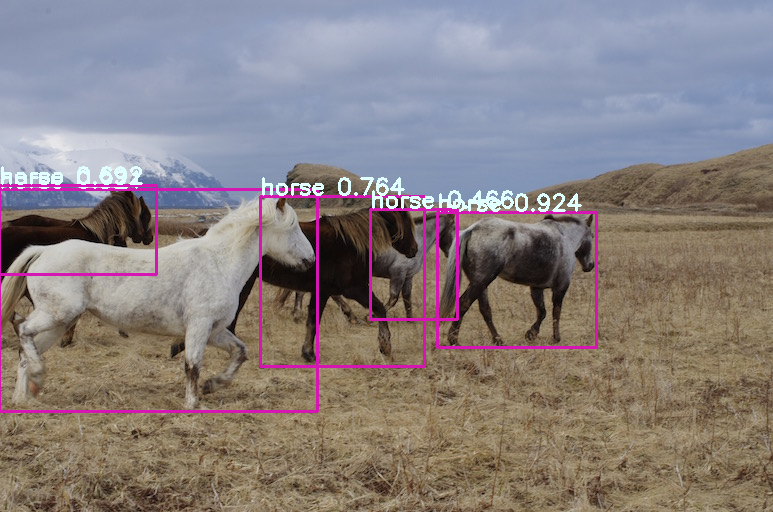

In [51]:
# visualize results
Image.fromarray(images_with_boxes[0])


## Verify model accuracy

### Download dataset

Yolo V7 tiny pretrained on COCO dataset, in order to evaluate model accuracy we need to download it. According to instruction, provided in model repo, we also need to download annotation in prepared by model author format for using original model evaluation scripts

In [73]:
from zipfile import ZipFile

sys.path.append("../../utils")
from notebook_utils import download_file

data_url = "http://images.cocodataset.org/zips/val2017.zip"
labels_url = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"

out_dir = Path('.')

download_file(data_url, directory=out_dir, show_progress=True)
download_file(labels_url, directory=out_dir, show_progress=True)
with ZipFile('coco2017labels-segments.zip' , "r") as zip_ref:
    zip_ref.extractall(out_dir)
with ZipFile('val2017.zip' , "r") as zip_ref:
    zip_ref.extractall(out_dir / 'coco/images')

val2017.zip:   0%|          | 0.00/778M [00:00<?, ?B/s]

coco2017labels-segments.zip:   0%|          | 0.00/169M [00:00<?, ?B/s]

### Create dataloader

In [101]:
from collections import namedtuple
import yaml
from utils.datasets import create_dataloader
from utils.general import (
    coco80_to_coco91_class, check_dataset, check_file, check_img_size, check_requirements,
    box_iou, non_max_suppression, scale_coords, xyxy2xywh, xywh2xyxy, set_logging, increment_path, colorstr
)

# read dataset config
data = 'data/coco.yaml'
with open(data) as f:
    data = yaml.load(f, Loader=yaml.SafeLoader)

# Dataloader
task = 'val'  # path to train/val/test images
Option = namedtuple('Options', ['single_cls']) # imitation of commandline provided options for single class evaluation
opt = Option(False)
dataloader = create_dataloader(data[task], 640, 1, 32, opt, pad=0.5, rect=True,
                                       prefix=colorstr(f'{task}: '))[0]


val: Scanning 'coco\val2017.cache' images and labels... 4952 found, 48 missing, 0 empty, 0 corrupted: 100%|██████████| 5000/5000 [00:00<?, ?it/s]


### Define validation function

We will reuse validation metrics provided in model repo with adoption to our case (removing extra steps). Original model evaluation procedure can be found in this [file](https://github.com/WongKinYiu/yolov7/blob/main/test.py)

In [107]:

import json
import os
from pathlib import Path

import numpy as np
import torch

from tqdm.notebook import tqdm


from utils.metrics import ap_per_class, ConfusionMatrix


# test function        
def test(data,
         model,
         dataloader,
         single_cls=False,
         save_dir=Path(''),  # for saving images
         is_coco=False,
         v5_metric=False):

    check_dataset(data)  # check
    nc = 1 if single_cls else int(data['nc'])  # number of classes
    iouv = torch.linspace(0.5, 0.95, 10)  # iou vector for mAP@0.5:0.95
    niou = iouv.numel()
    opt = Option(False)
    
    seen = 0
    confusion_matrix = ConfusionMatrix(nc=nc)
    coco91class = coco80_to_coco91_class()
    s = ('%20s' + '%12s' * 6) % ('Class', 'Images', 'Labels', 'P', 'R', 'mAP@.5', 'mAP@.5:.95')
    p, r, f1, mp, mr, map50, map, t0, t1 = 0., 0., 0., 0., 0., 0., 0., 0., 0.
    jdict, stats, ap, ap_class, wandb_images = [], [], [], [], []
    for batch_i, (img, targets, paths, shapes) in enumerate(tqdm(dataloader, desc=s)):
        img, ratio, dwdh = preprocess_image(np.transpose(img[0].numpy(), (1, 2, 0)))
        nb, _, height, width = img.shape  # batch size, channels, height, width
        # Run model
        out = model(img)[output]  # inference outputs
        out = get_boxes(out, dwdh, ratio, flatten=True)
        out = torch.from_numpy(np.array(out))
        targets[:, 2:] *= torch.Tensor([width, height, width, height])  # to pixels
        lb = []

        # Statistics per image
        for si, pred in enumerate(out):
            labels = targets[targets[:, 0] == si, 1:]
            nl = len(labels)
            tcls = labels[:, 0].tolist() if nl else []  # target class
            seen += 1

            if len(pred) == 0:
                if nl:
                    stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
                continue

            # Predictions
            predn = pred.clone()

            # Assign all predictions as incorrect
            correct = torch.zeros(pred.shape[0], niou, dtype=torch.bool)
            if nl:
                detected = []  # target indices
                tcls_tensor = labels[:, 0]

                # target boxes
                tbox = xywh2xyxy(labels[:, 1:5])
                scale_coords(img[si].shape[1:], tbox, shapes[si][0], shapes[si][1])  # native-space labels

                # Per target class
                for cls in torch.unique(tcls_tensor):
                    ti = (cls == tcls_tensor).nonzero(as_tuple=False).view(-1)  # prediction indices
                    pi = (cls == pred[:, 5]).nonzero(as_tuple=False).view(-1)  # target indices

                    # Search for detections
                    if pi.shape[0]:
                        # Prediction to target ious
                        ious, i = box_iou(predn[pi, :4], tbox[ti]).max(1)  # best ious, indices

                        # Append detections
                        detected_set = set()
                        for j in (ious > iouv[0]).nonzero(as_tuple=False):
                            d = ti[i[j]]  # detected target
                            if d.item() not in detected_set:
                                detected_set.add(d.item())
                                detected.append(d)
                                correct[pi[j]] = ious[j] > iouv  # iou_thres is 1xn
                                if len(detected) == nl:  # all targets already located in image
                                    break

            # Append statistics (correct, conf, pcls, tcls)
            stats.append((correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), tcls))

    # Compute statistics
    stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
    if len(stats) and stats[0].any():
        p, r, ap, f1, ap_class = ap_per_class(*stats, v5_metric=v5_metric, save_dir=save_dir, names=names)
        ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
        nt = np.bincount(stats[3].astype(np.int64), minlength=nc)  # number of targets per class
    else:
        nt = torch.zeros(1)

    return mp, mr, map50, map

In [ ]:
result = test(data=data, model=compiled_model, dataloader=dataloader)

## Optimize model using NNCF Postrainging Quantization API

In [ ]:
def transform_fn(data_batch):
    img = data_batch[0]
    img, _, _ = preprocess_image(np.transpose(img[0].numpy()))
    return img

quantization_dataset = nncf.create_dataloader(dataloader, transform_fn)

In [ ]:
quantized_model = nncf.quantize(ov_model, quantization_dataset, preset='mixed')

serialize(quantized_model. 'model/yolov7-tiny_int8.xml')

## Validate Quantized model inference

In [ ]:
compiled_int8_model = core.compile_model(quantized_model, 'CPU')
result = compiled_int8_model([im])[compiled_int8_model.output(0)]
boxes, scores, labels = get_boxes(result)
images_with_boxes = draw_boxes([img.copy()], boxes, scores, labels)
Image.fromarray(images_with_boxes[0])

## Validate quantized model accuracy

In [ ]:
int8_result = test(data=data, model=compiled_model, dataloader=dataloader)

## Compare Performance of the Original and Quantized Models
Finally, use [Benchmark Tool](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html) to measure the inference performance of the `FP16` and `INT8` models.

> NOTE: For more accurate performance, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app -m model.xml -d CPU` to benchmark async inference on CPU for one minute. Change `CPU` to `GPU` to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.

In [ ]:
# Inference FP16 model (OpenVINO IR)
!benchmark_app -m model/yolov7-tiny.xml -d CPU -api async

In [ ]:
# Inference FP16 model (OpenVINO IR)
!benchmark_app -m model/yolov7-tiny_int8.xml -d CPU -api async